# Segmenting the images by signal processing
In a ploy to increase the performance of our models, I'll be pre-segmenting the image so that they can be fed to the neural net, so that the inputs are already close to the output. I will be following the tutorials of this article: https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/

In [164]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from scipy import ndimage
import os,sys

In [11]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

In [26]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = img_float_to_uint8([load_image(image_dir + files[i]) for i in range(n)])

Loading 100 images


In [25]:
imgs[0].shape

(3, 400, 400)

# Region-based segmentation (threshold segmentation)
In this technique, the goal is to segment the image in a foreground and background, using a threshold.
The article suggests taking the average pixel value of the image as threshold, we can start here and refine it then.

Let's look at how our pictures look

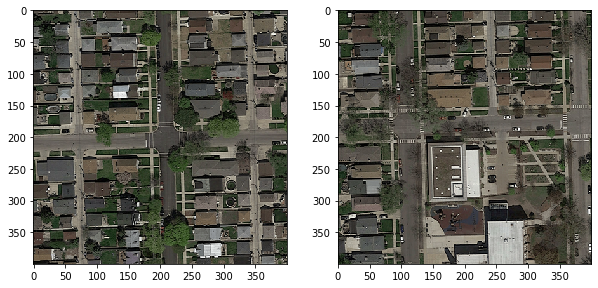

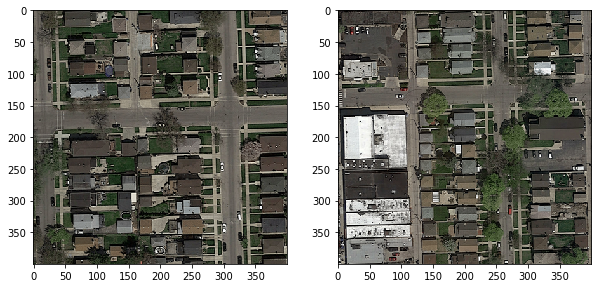

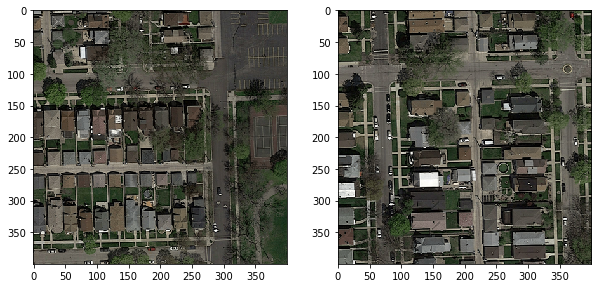

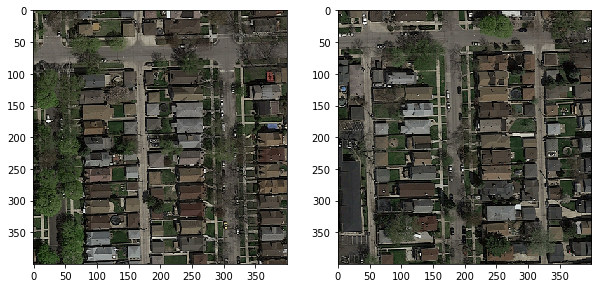

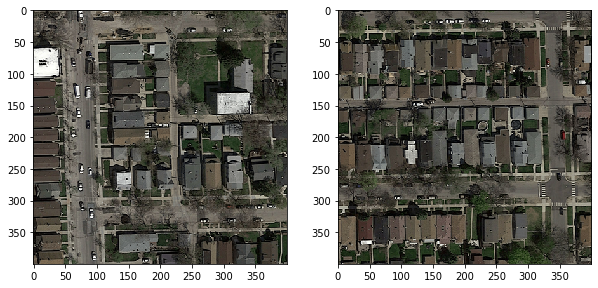

In [45]:
N = 10
for i in range(round(N/2)):
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(imgs[2*i])
    axarr[1].imshow(imgs[2*i+1])

In order to do the thresholding, we need to convert it to grayscale

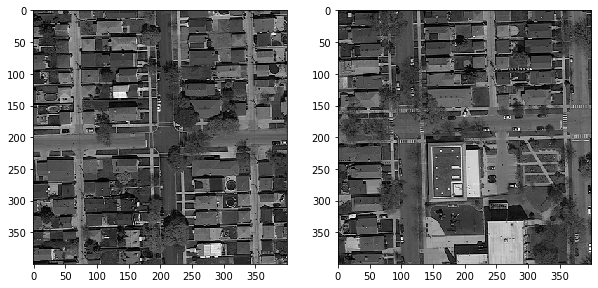

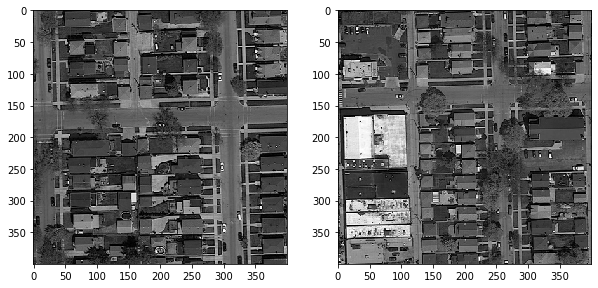

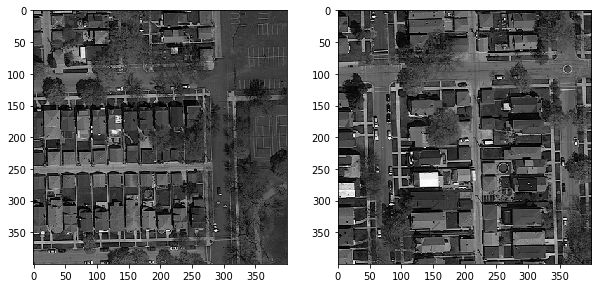

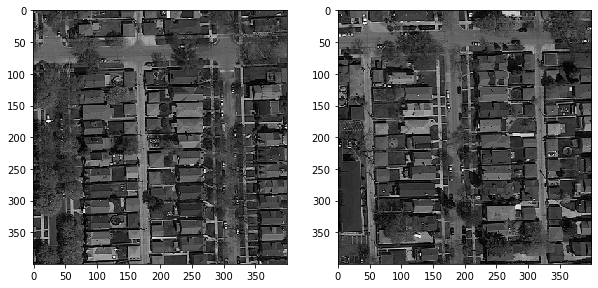

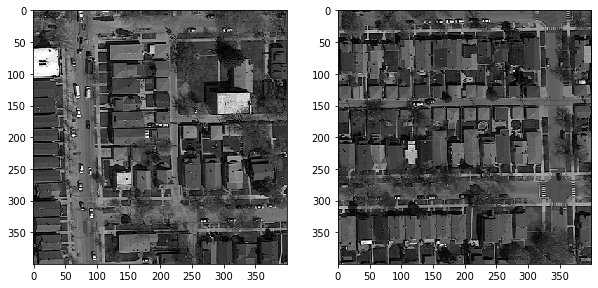

In [48]:
N = 10
for i in range(round(N/2)):
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(rgb2gray(imgs[2*i]), cmap='gray')
    axarr[1].imshow(rgb2gray(imgs[2*i+1]), cmap='gray')

Then we take the average pixel value and we use it as threshold

In [65]:
def apply_threshold(img, threshold):
    output = (np.sign(img - threshold*np.ones(img.shape)) + 1)/2
    return output

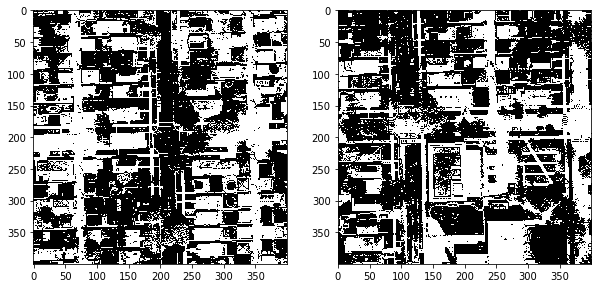

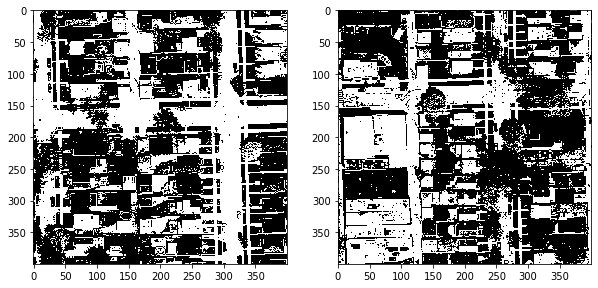

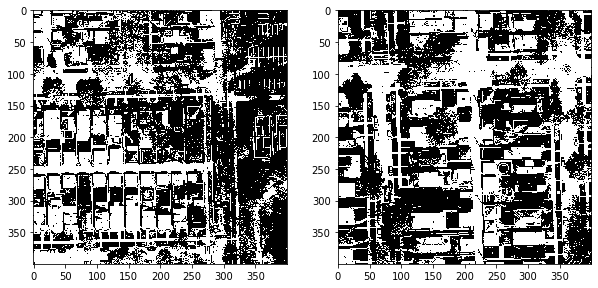

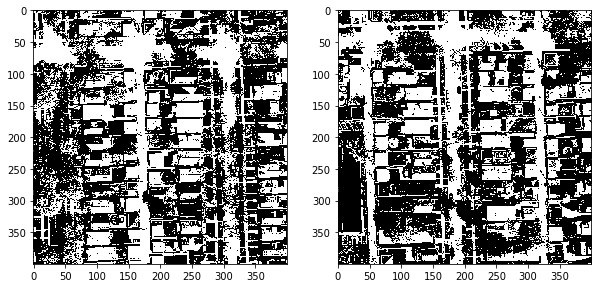

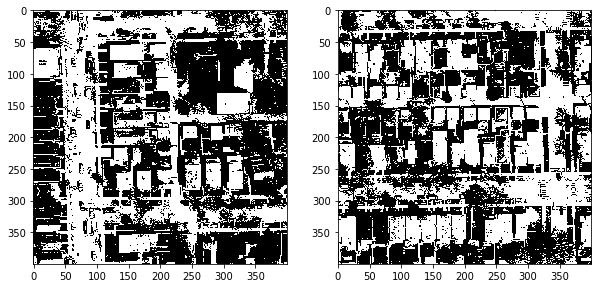

In [69]:
N = 10
for i in range(round(N/2)):
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    
    img1 = rgb2gray(imgs[2*i])
    thresh1 = img1.flatten().mean()
    
    img2 = rgb2gray(imgs[2*i+1])
    thresh2 = img2.flatten().mean()
    
    axarr[0].imshow(apply_threshold(img1, thresh1), cmap='gray')
    axarr[1].imshow(apply_threshold(img2, thresh2), cmap='gray')

We see that the average value can be pretty good in most instances, while it stilll misses some roads. We get some confusion with the houses. It can be possible to use two thresholds to separate background, road and houses, let's try this. Let's begin by looking at thresholds to see when elements appear

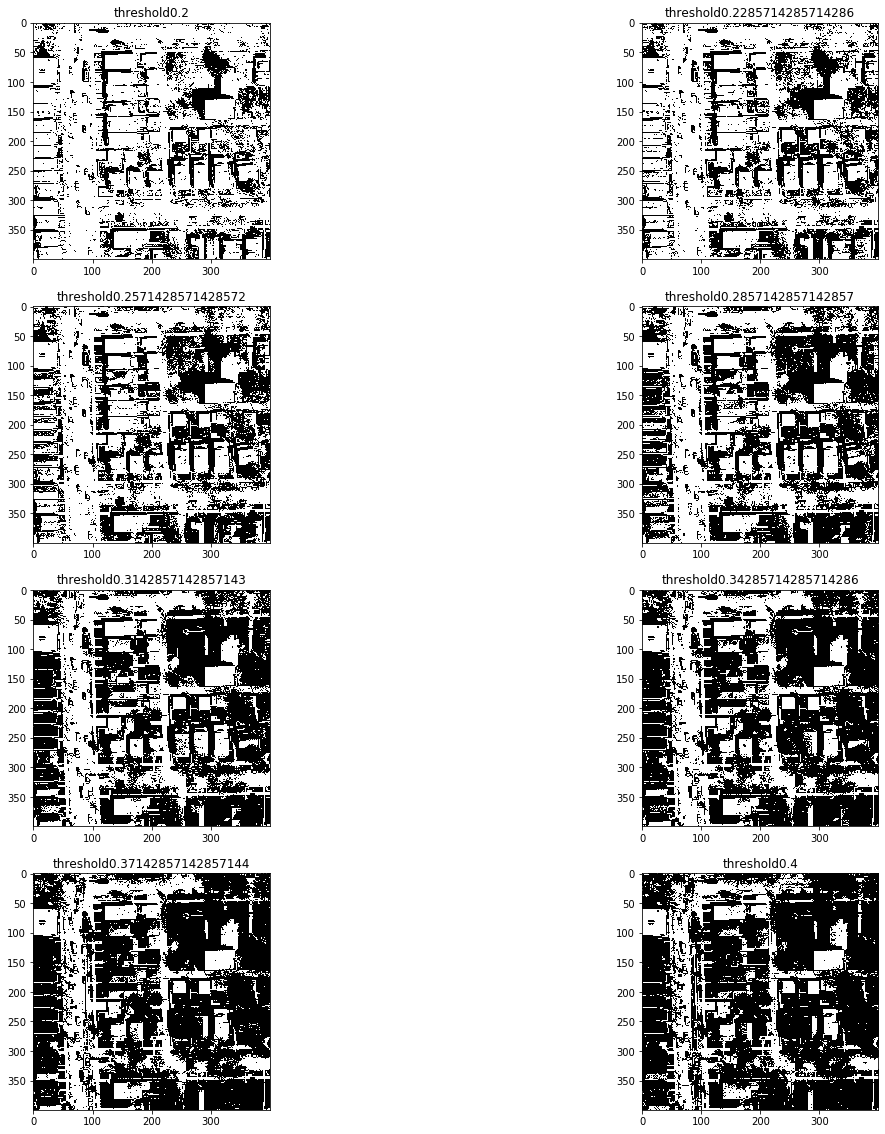

In [89]:
N = 8
M = round(N/2)
subplot_base_val = 100*M + 10*2
fig = plt.figure(figsize=(20,20))

thresholds = np.linspace(0.2,0.4,N)

for i in range(N):
    ax = fig.add_subplot(subplot_base_val+i+1)
    
    img = rgb2gray(imgs[0])
    
    ax.imshow(apply_threshold(img1, thresholds[i]), cmap='gray')
    ax.title.set_text('threshold' + str(thresholds[i]))

In this case, 0.3 looks like a threshold where both roads and houses are visible. This can be the threshold where we discriminate the background from everything else. Now let's look at a threshold to discriminate between roads and houses:

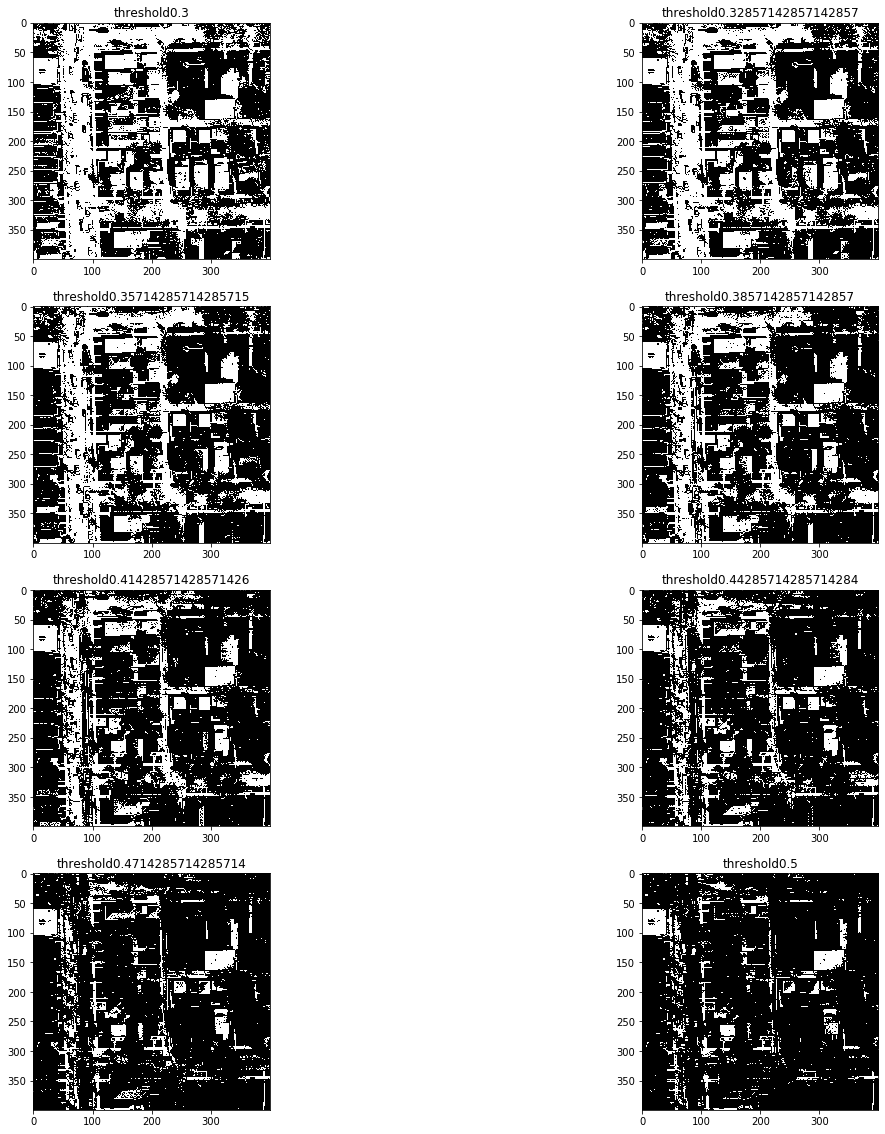

In [90]:
N = 8
M = round(N/2)
subplot_base_val = 100*M + 10*2
fig = plt.figure(figsize=(20,20))

thresholds = np.linspace(0.3,0.5,N)

for i in range(N):
    ax = fig.add_subplot(subplot_base_val+i+1)
    
    img = rgb2gray(imgs[0])
    
    ax.imshow(apply_threshold(img1, thresholds[i]), cmap='gray')
    ax.title.set_text('threshold' + str(thresholds[i]))

0.4 looks like the optimal threshold for this. Let's try those two thresholds on the images to see if it works well in general in our dataset

In [101]:
def apply_thresholds(img, thresholds):
    output = np.zeros(img.shape)
    
    for threshold in thresholds:
        output += threshold*(np.sign(img - threshold*np.ones(img.shape)) + 1)/2
        
    return output

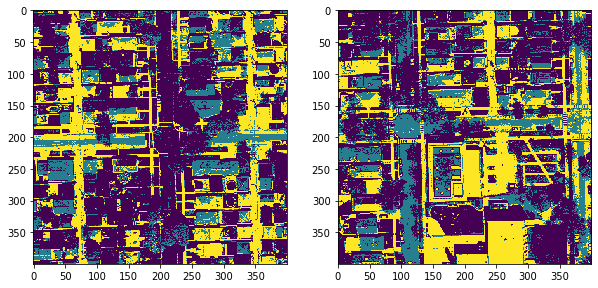

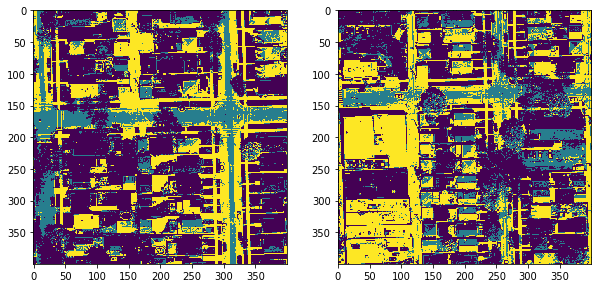

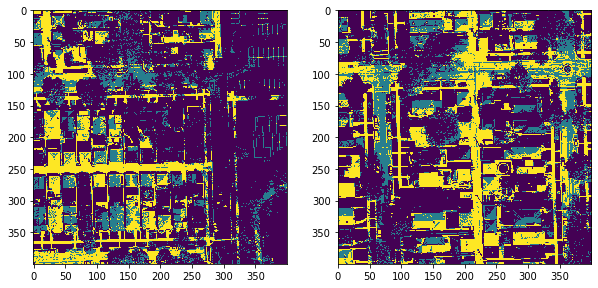

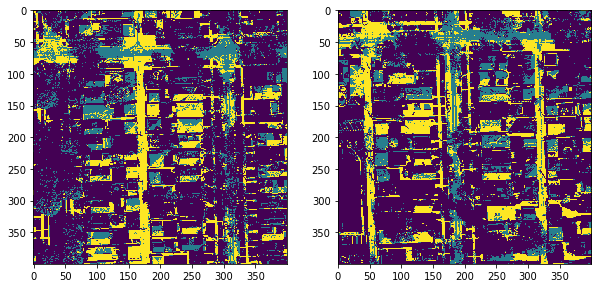

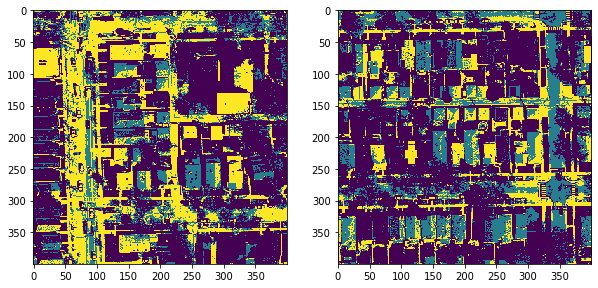

In [102]:
N = 10
thresholds = [0.3, 0.4]
for i in range(round(N/2)):
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    
    img1 = rgb2gray(imgs[2*i])
    
    img2 = rgb2gray(imgs[2*i+1])
    
    axarr[0].imshow(apply_thresholds(img1, thresholds))
    axarr[1].imshow(apply_thresholds(img2, thresholds))

Let's see how it looks if we extract only the supposedly "road" layer:

In [105]:
#this function takes in two thresholds and extracts what is inbetween those
def extract_thresholds(img, thresholds):
    output = np.zeros(img.shape)
    
    output = (np.sign(img - thresholds[0]*np.ones(img.shape)) + 1)/2
    output -= (np.sign(img - thresholds[1]*np.ones(img.shape)) + 1)/2
        
    return output

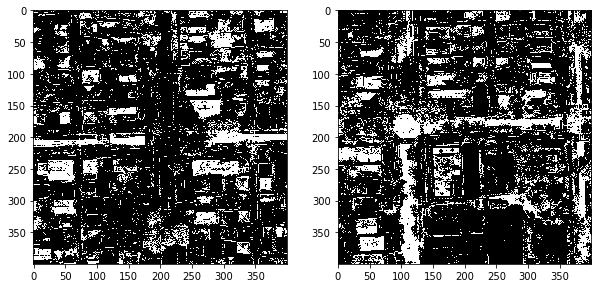

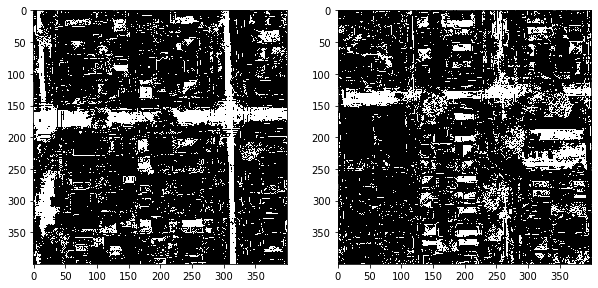

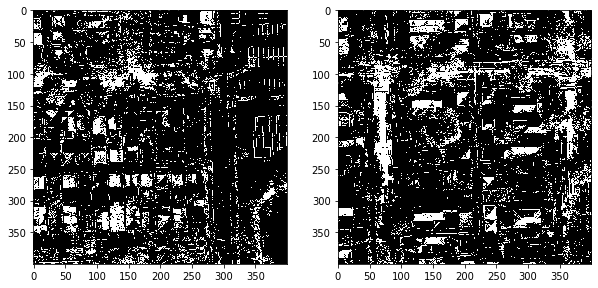

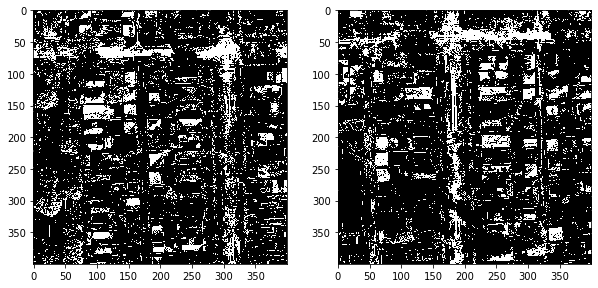

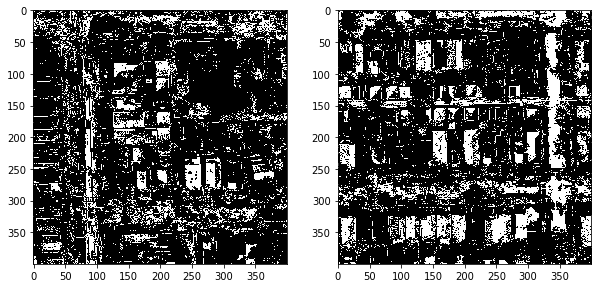

In [111]:
N = 10
thresholds = [0.3, 0.4]
for i in range(round(N/2)):
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    
    img1 = rgb2gray(imgs[2*i])
    
    img2 = rgb2gray(imgs[2*i+1])
    
    axarr[0].imshow(extract_thresholds(img1, thresholds), cmap='gray')
    axarr[1].imshow(extract_thresholds(img2, thresholds), cmap='gray')

This is not really good but it's close. Let's see the other segmentation possibilities

# Edge detection segmentation
We can use filters to detect the edges of roads

In [112]:
sobel_horizontal = np.array([np.array([1, 2, 1]), np.array([0, 0, 0]), np.array([-1, -2, -1])])
 
sobel_vertical = np.array([np.array([-1, 0, 1]), np.array([-2, 0, 2]), np.array([-1, 0, 1])])

kernel_laplace = np.array([np.array([1, 1, 1]), np.array([1, -8, 1]), np.array([1, 1, 1])])

## Horizontal detection

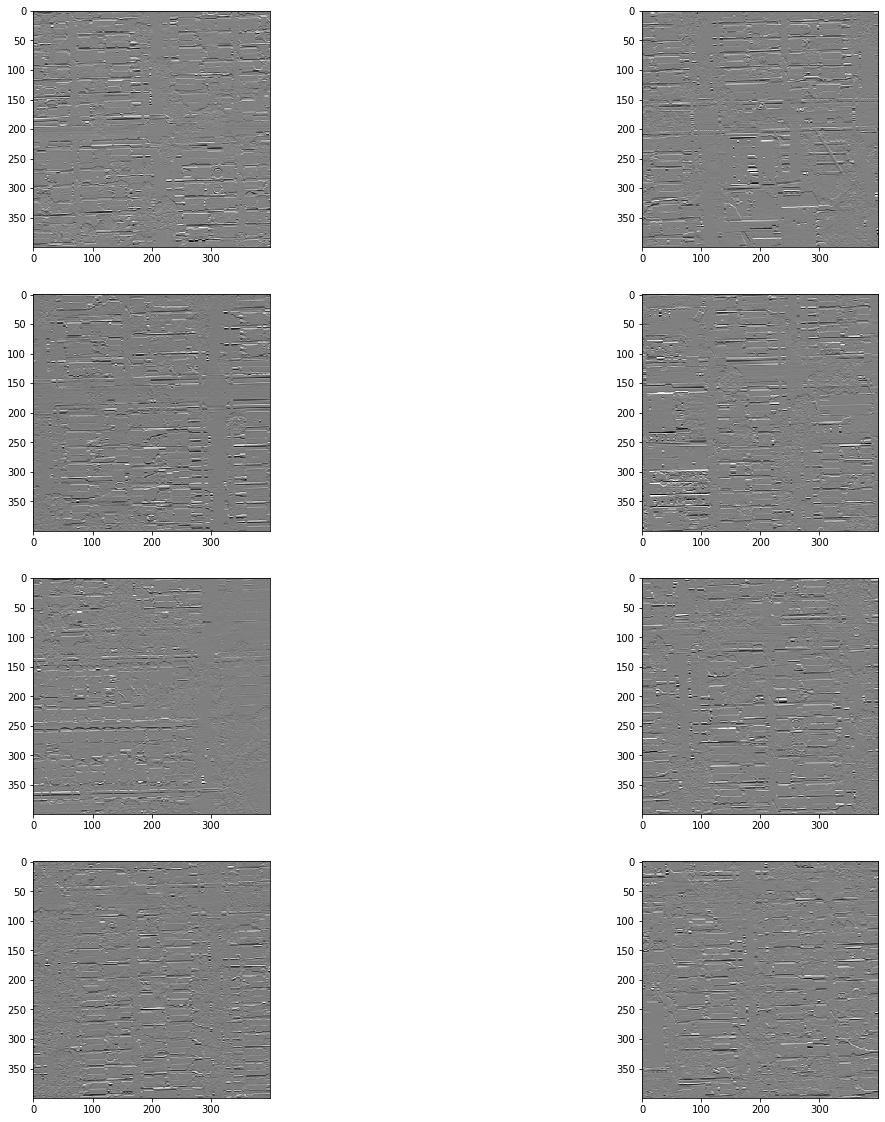

In [114]:
N = 8
M = round(N/2)
subplot_base_val = 100*M + 10*2
fig = plt.figure(figsize=(20,20))

for i in range(N):
    ax = fig.add_subplot(subplot_base_val+i+1)
    
    img = rgb2gray(imgs[i])
    
    ax.imshow(ndimage.convolve(img, sobel_horizontal, mode='reflect'), cmap='gray')

Pas grand chose, mais bon on est là

## Vertical detection

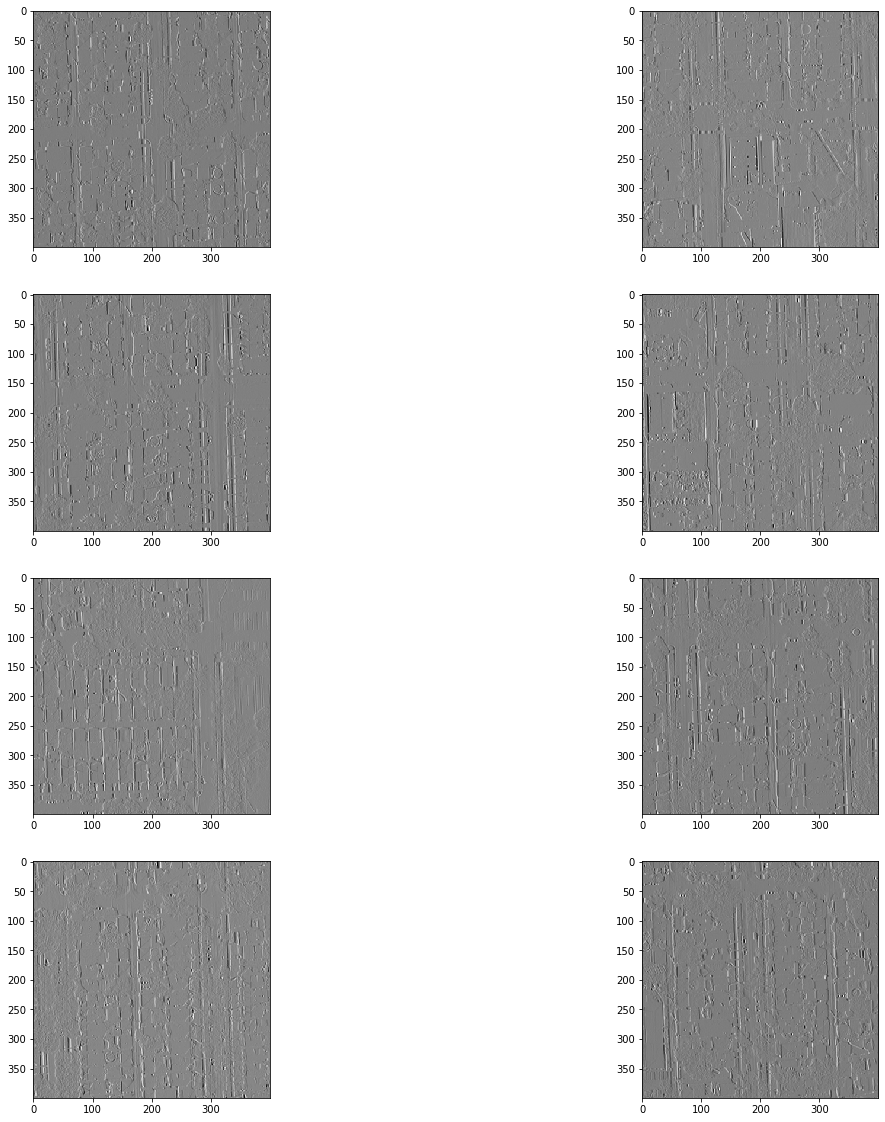

In [115]:
N = 8
M = round(N/2)
subplot_base_val = 100*M + 10*2
fig = plt.figure(figsize=(20,20))

for i in range(N):
    ax = fig.add_subplot(subplot_base_val+i+1)
    
    img = rgb2gray(imgs[i])
    
    ax.imshow(ndimage.convolve(img, sobel_vertical, mode='reflect'), cmap='gray')

## Bidirectional laplace edge detection

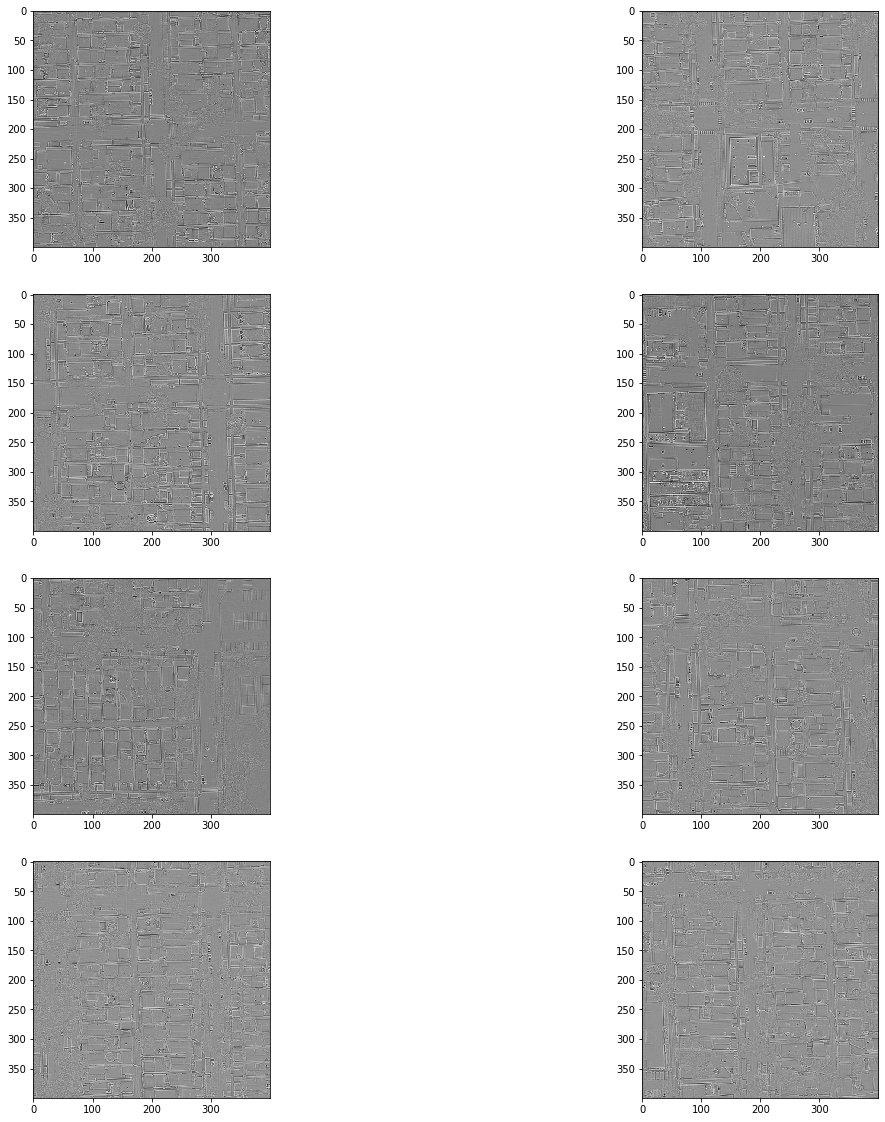

In [116]:
N = 8
M = round(N/2)
subplot_base_val = 100*M + 10*2
fig = plt.figure(figsize=(20,20))

for i in range(N):
    ax = fig.add_subplot(subplot_base_val+i+1)
    
    img = rgb2gray(imgs[i])
    
    ax.imshow(ndimage.convolve(img, kernel_laplace, mode='reflect'), cmap='gray')

This is a bit better but not really good...

# Clustering with K-means

In [124]:
from sklearn.cluster import KMeans

In [145]:
def segment_image_kmeans(img, cluster_nb):
    pic = img/255  # dividing by 255 to bring the pixel values between 0 and 1
    pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
    kmeans = KMeans(n_clusters=cluster_nb, random_state=0).fit(pic_n)
    pic2show = kmeans.cluster_centers_[kmeans.labels_]
    cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
    return cluster_pic

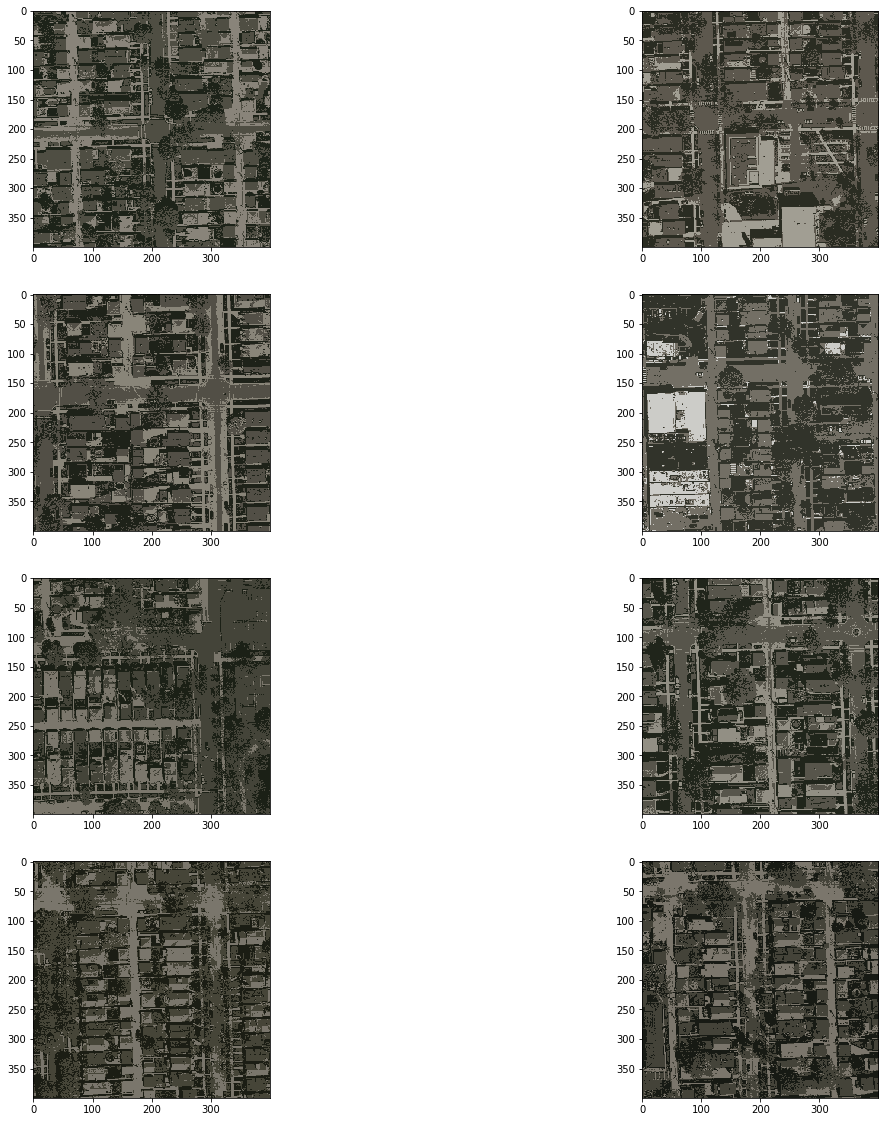

In [148]:
N = 8
M = round(N/2)
subplot_base_val = 100*M + 10*2
fig = plt.figure(figsize=(20,20))

for i in range(N):
    ax = fig.add_subplot(subplot_base_val+i+1)
    
    ax.imshow(segment_image_kmeans(imgs[i], 3), cmap='gray')

This clustering technique consistently finds the roads, although different roads might be in different clusters, and houses still find their way in the clusters

In [150]:
segmented_img = segment_image_kmeans(imgs[50], 3)

# Conclusion
Nothing is really convincing, but we can try using the threhsold extraction with a CNN to see if it works. I will write a function that segments the inputs of the dataset